# Image classification: French cheeses

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [ ]:

data_dir = pathlib.Path('data/auto_dataset_cleaned')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f"Found {image_count} jpg and jpeg images.")

## Create a tf.keras dataset

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

## Visualize the data

Here are the first nine images from the training dataset:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [77]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

96/96 [==============================] - 132s 1s/step - loss: 0.4743 - accuracy: 0.8379 - val_loss: 2.6054 - val_accuracy: 0.4567


## Visualize training results

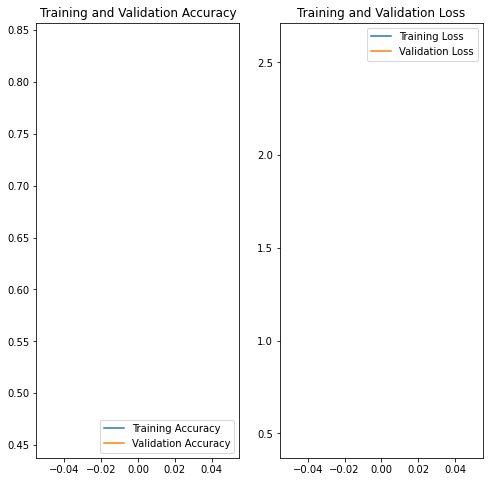

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [65]:
from IPython.display import display

def cheezam(filepath : str):
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display( PIL.Image.open(filepath).resize((256,256)))

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

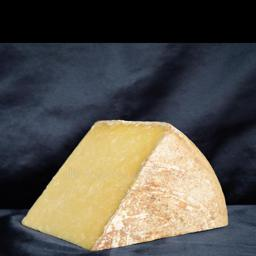

This cheese is most likely a Cantal with a 81.71 percent confidence.


In [79]:
cheezam('data/test/test2.jpg')

10


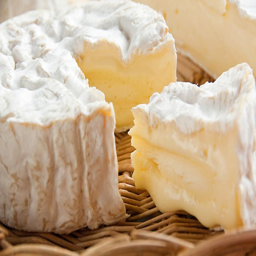

This cheese is most likely a Camembert de Normandie with a 61.65 percent confidence.


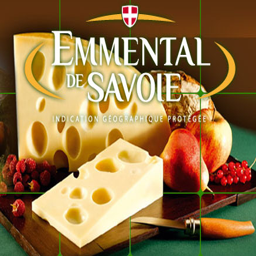

This cheese is most likely a Camembert de Normandie with a 99.89 percent confidence.


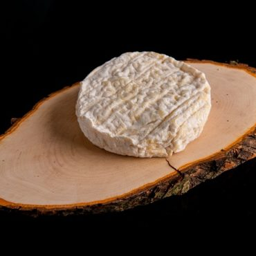

This cheese is most likely a Camembert de Normandie with a 92.26 percent confidence.


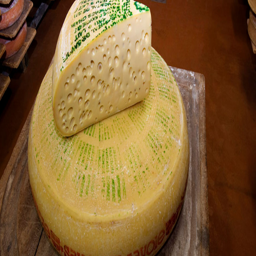

This cheese is most likely a Cantal with a 94.98 percent confidence.


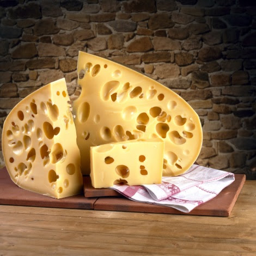

This cheese is most likely a Emmenthal de Savoie with a 97.93 percent confidence.


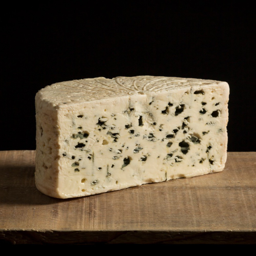

This cheese is most likely a Roquefort with a 100.00 percent confidence.


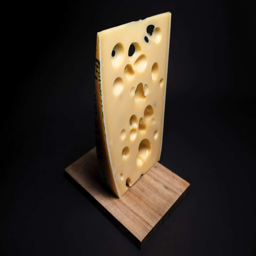

This cheese is most likely a Emmenthal de Savoie with a 86.97 percent confidence.


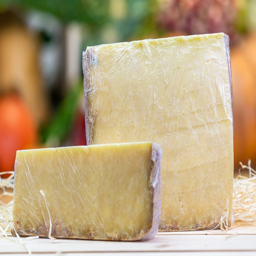

This cheese is most likely a Rocamadour with a 89.64 percent confidence.


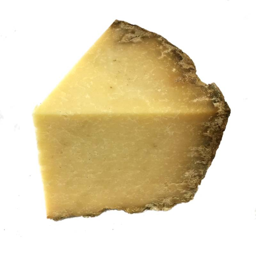

This cheese is most likely a Cantal with a 66.10 percent confidence.


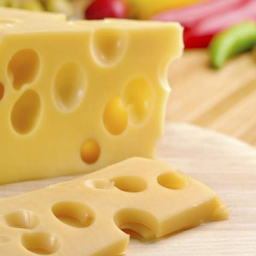

This cheese is most likely a Cantal with a 92.74 percent confidence.


In [80]:
import random
test_dir = pathlib.Path('data/sample_dataset')
test_paths_total = list(test_dir.glob('*/*.jpg'))
nb_test, nb_test_total = 10, len(test_paths_total)
test_paths = random.sample(test_paths_total, nb_test)
print(len(test_paths))
for test_path in test_paths:
    cheezam(test_path)

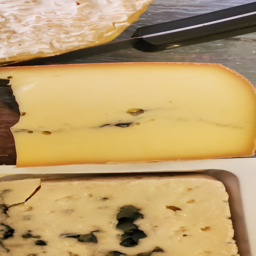

This cheese is most likely a Morbier with a 90.99 percent confidence.


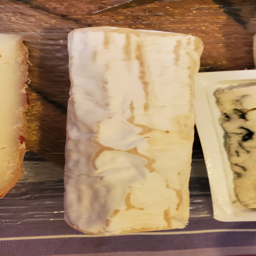

This cheese is most likely a Emmenthal de Savoie with a 35.15 percent confidence.


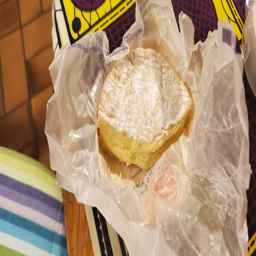

This cheese is most likely a Fourme de Montbrison with a 40.57 percent confidence.


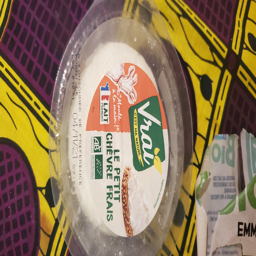

This cheese is most likely a Cantal with a 97.37 percent confidence.


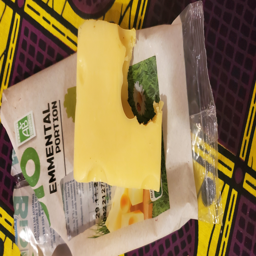

This cheese is most likely a Comte with a 97.78 percent confidence.


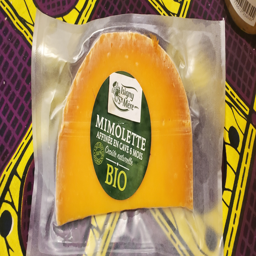

This cheese is most likely a Mimolette with a 99.95 percent confidence.


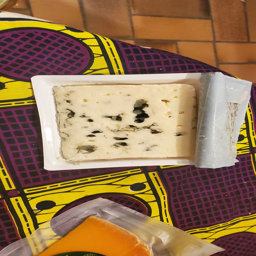

This cheese is most likely a Fourme d'Ambert with a 49.98 percent confidence.


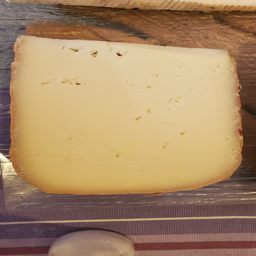

This cheese is most likely a Saint-Nectaire with a 85.65 percent confidence.


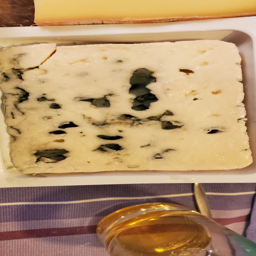

This cheese is most likely a Morbier with a 93.47 percent confidence.


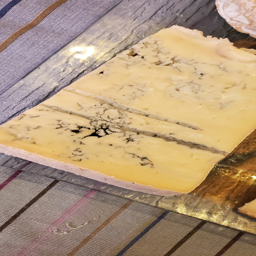

This cheese is most likely a Morbier with a 94.10 percent confidence.


In [73]:
photos_brice_dir = pathlib.Path('data/photos_brice')
photos_brice_paths = list(photos_brice_dir.glob('*.jpg'))
for photo in photos_brice_paths:
    cheezam(photo)